# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import seaborn as sns

## Data import and cleanup

In [2]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
print(bwt_df.shape)
bwt_df.head()

(1174, 7)


,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [3]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [4]:
bwt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 7 columns):
bwt          1174 non-null int64
gestation    1174 non-null int64
parity       1174 non-null int64
age          1174 non-null int64
height       1174 non-null int64
weight       1174 non-null int64
smoke        1174 non-null int64
dtypes: int64(7)
memory usage: 64.3 KB


## Quantile Regression

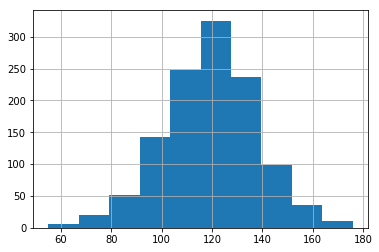

In [5]:
# Visualize!
bwt_df.bwt.hist()

In [6]:
# First, I figure out what quantile corresponds to a birth weight 
# of 90 oz.
q = stats.percentileofscore(bwt_df.bwt, 90)/100
q

0.05664395229982964

In [7]:
# Now let's construct the formula string using all columns
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=q)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke


/anaconda3/envs/sandbox/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.228
Method:                 Least Squares   Sparsity:                        132.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        14:33:30   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.271     -32.393
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1.337
age           -0.0836      0.172     -0.486      0.627      -0.421       0.254
height         1.2308      0.437      2.817      0.005       0.374       2.088
weight        -0.1191      0.058     -2.048      0.041      -0.233      -0.005
smoke         -8.7485      1.855     -4.716      0.000     -12.388      -5.109
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Quick check to see if Linear Regression results look similar
X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

coefficients = linear_reg.coef_    # array
intercept = linear_reg.intercept_

print(f"Intercept   : {intercept:.2f}")
print("\nCoefficients:\n")
for var, coef in zip(X.columns, coefficients):
    print(f'{var:>12}: {coef:.4f}')

Intercept   : -80.41

Coefficients:

   gestation: 0.4440
      parity: -3.3272
         age: -0.0090
      height: 1.1540
      weight: 0.0502
       smoke: -8.4007


Sure enough, even lots of the coefficients look just the same.

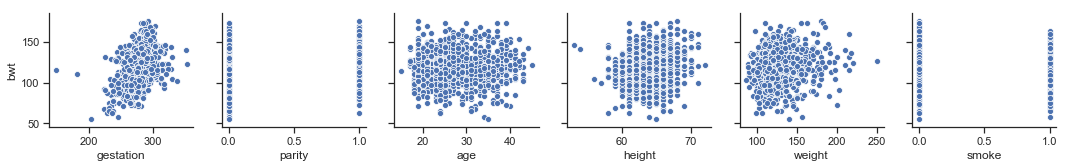

In [9]:
# Let's visualize to see if there's any obvious nonlinear relationships
X = bwt_df.drop(columns='bwt')

sns.set(style="ticks", color_codes=True)
# y_vars and x_vars are lists of column names.
sns.pairplot(data=bwt_df, y_vars=['bwt'], x_vars=X.columns)
plt.show()

## Feature Engineering

In [20]:
df2 = bwt_df.copy()
# Squared Age
df2['BMI'] = df2['weight']*0.454 / (df2['height']*0.0254)**2
# Age * weight
df2['weight-age'] = df2['weight']*df2['age']
# Squared weight
df2['age_sq'] = df2['age']**2
# BMI
df2['weight_sq'] = df2['weight']**2
# Squared height
df2['height_sq'] = df2['height']**2


In [17]:
df2.head()

,bwt,gestation,parity,age,height,weight,smoke,BMI,age_sq,weight_sq,height_sq
0,120,284,0,27,62,100,0,18.306488,729,10000,3844
1,113,282,0,33,64,135,0,23.193284,1089,18225,4096
2,128,279,0,28,64,115,1,19.757242,784,13225,4096
3,108,282,0,23,67,125,1,19.595161,529,15625,4489
4,136,286,0,25,62,93,0,17.025034,625,8649,3844


In [18]:
quant_formula = 'bwt ~ ' + ' + '.join(df2.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df2)
quant_reg = quant_mod.fit(q=q)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke + BMI + age_sq + weight_sq + height_sq


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2059
Model:                       QuantReg   Bandwidth:                       6.264
Method:                 Least Squares   Sparsity:                        113.2
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        14:36:06   Df Residuals:                     1163
                                        Df Model:                           10
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0246    381.489  -6.44e-05      1.000    -748.509     748.460
gestation      0.4852      0.078      6.205      0.000       0.332       0.639
parity        -2.9156      2.083     -1.400      0.162      -7.002       1.171
age            0.1397      1.163      0.120      0.904      -2.142       2.421
height        -0.1567     11.105     -0.014      0.989     -21.945      21.631
weight         1.7716      0.604      2.932      0.003       0.586       2.957
smoke         -8.9011      1.632     -5.452      0.000     -12.104      -5.698
BMI           -5.2305      2.539     -2.060      0.040     -10.212      -0.249
age_sq        -0.0054      0.019     -0.276      0.783      -0.044       0.033
weight_sq     -0.0034      0.001     -3.932      0.000      -0.005      -0.002
height_sq     -0.0194      0.082     -0.238      0.812      -0.180       0.141
==============================================================================

The condition number is large, 9.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Visualization

For lack of anything better to plot, I'm going to create a scatterplot of birth weight vs gestation time and show how different quantile regressions would line up with it. 

In [29]:
quant_formula = 'bwt ~ ' + ' + '.join(df2.drop('bwt', axis='columns').columns)

mod = smf.quantreg(quant_formula, data=df2)

# I'll test 10 quantiles between 5% and 95%,
quantiles = np.arange(.05, .96, .1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['gestation']]
  
# Create dataframe of the quantile, intercept, and slope for each quantile
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b'])

# Create dict of intercept and slope, using linear regression
ols = smf.ols(quant_formula, df2).fit()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['gestation'])

print(models)
print(ols)


bwt ~ gestation + parity + age + height + weight + smoke + BMI + weight-age + age_sq + weight_sq + height_sq


/anaconda3/envs/sandbox/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


      q         a         b
0  0.05 -0.055653  0.508046
1  0.15 -0.044725  0.424882
2  0.25 -0.034373  0.504735
3  0.35 -0.067484  0.459443
4  0.45 -0.094015  0.468608
5  0.55 -0.107157  0.473647
6  0.65 -0.122785  0.446308
7  0.75 -0.131908  0.367332
8  0.85 -0.100519  0.345839
9  0.95 -0.013418  0.417238
{'a': 329.4701533952457, 'b': 0.44497515141652433}


Text(0.5,1,'Quantile vs. Linear Regression')

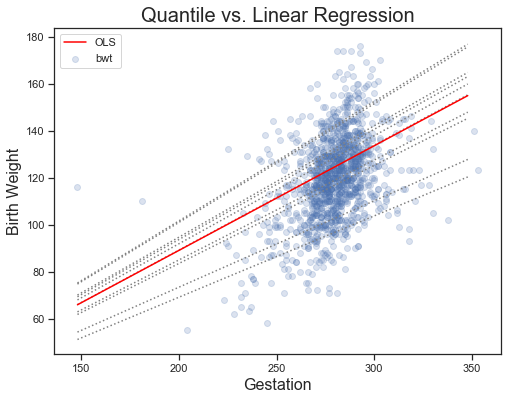

In [38]:
# Plot all the lines corresponding to the linear and quantile regression
x = np.arange(df2.gestation.min(), df2.gestation.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
# For some reason that I can't figure out, the intercept for the linear regression is 
# totally wrong.  I'll replace it with 0, which is close to the intercept from the
# quantile regression
y = get_y(0, ols['b'])
ax.plot(x, y, color='red', label='OLS')
ax.scatter(df2.gestation, df2.bwt, alpha=.2)
legend = ax.legend()
ax.set_xlabel('Gestation', fontsize=16)
ax.set_ylabel('Birth Weight', fontsize=16);
plt.title('Quantile vs. Linear Regression', fontsize=20);

# Tables revisited

In [43]:
# Table with original features
q = stats.percentileofscore(bwt_df.bwt, 90)/100
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=q)
print(quant_reg.summary())  # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.228
Method:                 Least Squares   Sparsity:                        132.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        15:41:16   Df Residuals:                     1167
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.271     -32.393
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1.337
age           -0.0836      0.172     -0.486      0.6

In [44]:
# Table with engineered features
quant_formula = 'bwt ~ ' + ' + '.join(df2.drop('bwt', axis='columns').columns)
quant_mod = smf.quantreg(quant_formula, data=df2)
quant_reg = quant_mod.fit(q=q)
print(quant_reg.summary()) # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.2059
Model:                       QuantReg   Bandwidth:                       6.270
Method:                 Least Squares   Sparsity:                        112.9
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        15:41:18   Df Residuals:                     1164
                                        Df Model:                            9
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0275    381.415  -7.21e-05      1.000    -748.364     748.309
gestation      0.4879      0.078      6.258      0.000       0.335       0.641
parity        -3.0175      1.969     -1.533      0.126      -6.880       0.845
height        -0.0768     11.087     -0.007      0.9

# Conclusions

### What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
Smoking status is the worst by far.  It shows up in both versions of my regression, has a really large coefficient, and is definitely significant. Height appears to have an effect when I run the original variables; adding engineered variables shows that actually height on its own doesn't matter, but BMI does. Weight is slightly significant in the original, and the engineered variables show that both weight and weight^2 are significant (especially weight^2).  This suggests that weight is important, and *especially* important when the weight is excessive.  To my surprise, age does not appear to be significant, and neither is age^2.

### What can expectant mothers be told to help mitigate this risk?
The main advice, as in many cases, is keep your weight under control and DO NOT SMOKE. Oh, and things will be easier after the first pregnancy. Stay strong!

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model